<a href="https://colab.research.google.com/github/DwiBagiaSantosa/AI-Paintings-vs-Human-Paintings/blob/master/notebooks/ModelingScenario6TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library yang dibutuhkan

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import pathlib
import numpy as np
import matplotlib.pylab as plt

In [ ]:
print(tf. __version__)

2.15.0


# Download Dataset

In [ ]:
# download dataset

!gdown 'https://drive.google.com/uc?id=1tKGCqhWw49AWo2zNrNYE_YYj914cNlgZ' -O dataset_bersih.zip
!unzip -q dataset_bersih.zip
!mv /content/content/dataset /content
!rm -rf /content/content

Downloading...
From (original): https://drive.google.com/uc?id=1tKGCqhWw49AWo2zNrNYE_YYj914cNlgZ
From (redirected): https://drive.google.com/uc?id=1tKGCqhWw49AWo2zNrNYE_YYj914cNlgZ&confirm=t&uuid=a0b276e0-7de2-474c-81e3-01b3b4a3db10
To: /content/dataset_bersih.zip
100% 27.8M/27.8M [00:00<00:00, 103MB/s] 


# Deklarasi path Dataset

In [ ]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

# konfigurasi MobileNetV2

In [ ]:
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Menggunakan {} dengan input size {} dan output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Menggunakan https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 dengan input size (224, 224) dan output dimension 1280


# Data Augmentation

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 800 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


# Menyimpan Label ke file label.txt

In [ ]:
class_names = list(train_generator.class_indices.keys())

with open('label.txt', 'w') as f:
    f.write('\n'.join(class_names))

# Setup Arsitektur MobileNetV2

In [ ]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=False
)

# Model yang dibangun

In [ ]:
# print("Buat Model menggunakan", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 657924 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training Model

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
25/25 [==============================] - 28s 408ms/step - loss: 1.0859 - accuracy: 0.5437 - val_loss: 0.4872 - val_accuracy: 0.8200
Epoch 2/10
25/25 [==============================] - 10s 383ms/step - loss: 0.5104 - accuracy: 0.8037 - val_loss: 0.3169 - val_accuracy: 0.9100
Epoch 3/10
25/25 [==============================] - 10s 416ms/step - loss: 0.3806 - accuracy: 0.8612 - val_loss: 0.2537 - val_accuracy: 0.9200
Epoch 4/10
25/25 [==============================] - 12s 466ms/step - loss: 0.3124 - accuracy: 0.8950 - val_loss: 0.2187 - val_accuracy: 0.9300
Epoch 5/10
25/25 [==============================] - 10s 418ms/step - loss: 0.2409 - accuracy: 0.9200 - val_loss: 0.2084 - val_accuracy: 0.9400
Epoch 6/10
25/25 [==============================] - 10s 387ms/step - loss: 0.2097 - accuracy: 0.9337 - val_loss: 0.1876 - val_accuracy: 0.9400
Epoch 7/10
25/25 [==============================] - 10s 368ms/step - loss: 0.1835 - accuracy: 0.9362 - val_loss: 0.1921 - val_accuracy: 0.9400

# Hasil Training

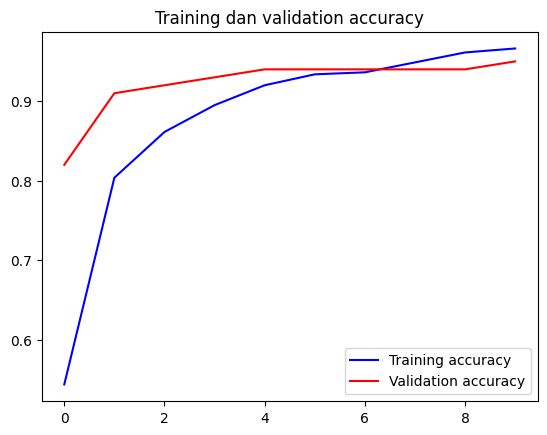

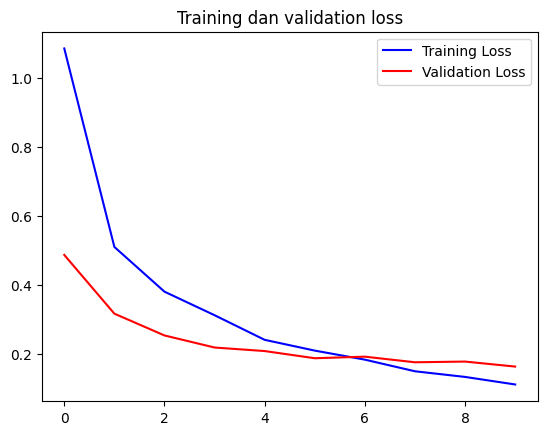

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training dan validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training dan validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate final score on Validation and Testing data

scores = model.evaluate(validation_generator)
scores = model.evaluate(test_generator)

4/4 [==============================] - 0s 57ms/step - loss: 0.1696 - accuracy: 0.9300


## Hasil :
- Training : 96,63 %
- Validation : 95 %
- Test : 93 %

# Save Model Ke Gdrive

In [ ]:
model.save('GAN_Counter_Scenario6.h5')
model.save('GAN_Counter_Scenario6')
!zip -r 'GAN_Counter_Scenario6.zip' 'GAN_Counter_Scenario6'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  adding: GAN_Counter_Scenario6/ (stored 0%)
  adding: GAN_Counter_Scenario6/fingerprint.pb (stored 0%)
  adding: GAN_Counter_Scenario6/saved_model.pb (deflated 91%)
  adding: GAN_Counter_Scenario6/assets/ (stored 0%)
  adding: GAN_Counter_Scenario6/keras_metadata.pb (deflated 85%)
  adding: GAN_Counter_Scenario6/variables/ (stored 0%)
  adding: GAN_Counter_Scenario6/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: GAN_Counter_Scenario6/variables/variables.index (deflated 78%)


## Convert model menjadi TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('GAN_Counter_Scenario6')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./GAN_Counter_Scenario6.tflite')

print("TFLite model conversion and saving complete.")

bytes = tflite_model_file.write_bytes(tflite_model)
megabytes = bytes / (1024 * 1024)
print(f"Model size setelah menjadi TFLite : {megabytes:.2f} Mb")

TFLite model conversion and saving complete.
Model size setelah menjadi TFLite : 3.02 Mb


In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Copy Model ke gdrive

!cp -r "GAN_Counter_Scenario6.h5" "drive/MyDrive/Tugas Akhir or Skripsian/Model/"
!cp -r "GAN_Counter_Scenario6.tflite" "drive/MyDrive/Tugas Akhir or Skripsian/Model/"

In [ ]:
# Cek dataset yang sudah tersimpan

!ls "drive/MyDrive/Tugas Akhir or Skripsian/Model/"

GAN_Counter.h5		      GAN_Counter_Scenario3.tflite  GAN_Counter_Scenario6.h5
GAN_Counter_Scenario1.tflite  GAN_Counter_Scenario4.h5	    GAN_Counter_Scenario6.tflite
GAN_Counter_Scenario2.h5      GAN_Counter_Scenario4.tflite  GAN_Counter_Test.h5
GAN_Counter_Scenario2.tflite  GAN_Counter_Scenario5.h5	    label.txt
GAN_Counter_Scenario3.h5      GAN_Counter_Scenario5.tflite


# Evaluasi

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

4/4 [==============================] - 2s 179ms/step
Classification Report
                        precision    recall  f1-score   support

Landscape_AI_Generated       0.96      0.96      0.96        25
  Landscape_Human_Made       0.96      0.96      0.96        25
  Potrait_AI_Generated       0.88      0.92      0.90        25
    Potrait_Human_Made       0.92      0.88      0.90        25

              accuracy                           0.93       100
             macro avg       0.93      0.93      0.93       100
          weighted avg       0.93      0.93      0.93       100



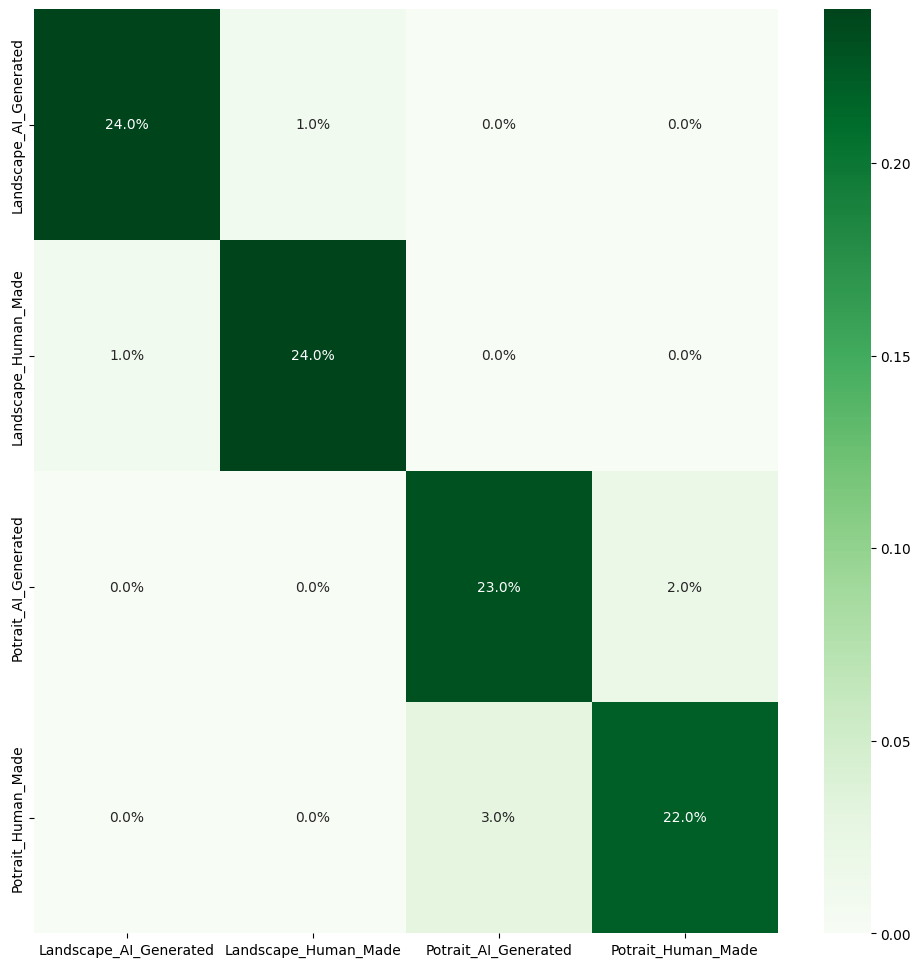

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,12))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap="Greens", xticklabels=class_names, yticklabels=class_names)

plt.show()